**loading datasets from kaggle**

In [7]:
!pip install -q kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c digit-recognizer
!unzip digit-recognizer.zip -d /content/

 85% 13.0M/15.3M [00:01<00:00, 14.7MB/s]
100% 15.3M/15.3M [00:01<00:00, 9.06MB/s]
Archive:  digit-recognizer.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.csv       
  inflating: /content/train.csv      


Handwritten Digit Recognition - MNIST Dataset - CNN - Python/Keras

**Key Design Considerations**

This is a Multi-Class Classification problem (10 classes)



*  Language: Python

*  Deep Learning Package: Keras
*  Dataset: MNIST dataset available with Keras


*   Model: MLP, CNN



**Load Dataset**

Load train and test datasets

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [11]:
train_df=pd.read_csv('/content/train.csv')
test_df=pd.read_csv('/content/test.csv')

In [12]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Training Set**

In [13]:
train_df.shape

(42000, 785)

**Test Set**

In [14]:
test_df.shape

(28000, 784)

**split data for features and labels**

In [20]:
x=train_df.drop('label',axis=1)
y=train_df['label']

**check null value**

In [21]:
x.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


In [ ]:
test_df.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


**scalling for images**

In [22]:
x=x/255
test_df=test_df/255

In [23]:
x = x.values.reshape(-1,28,28,1)
test_df = test_df.values.reshape(-1,28,28,1)

**Dataset Visualization**

Let us visualize the handwritten digit images and labels for 0th training sample. We can see that the 0th image shows a handwritten 5 and the 0th label has the value 5

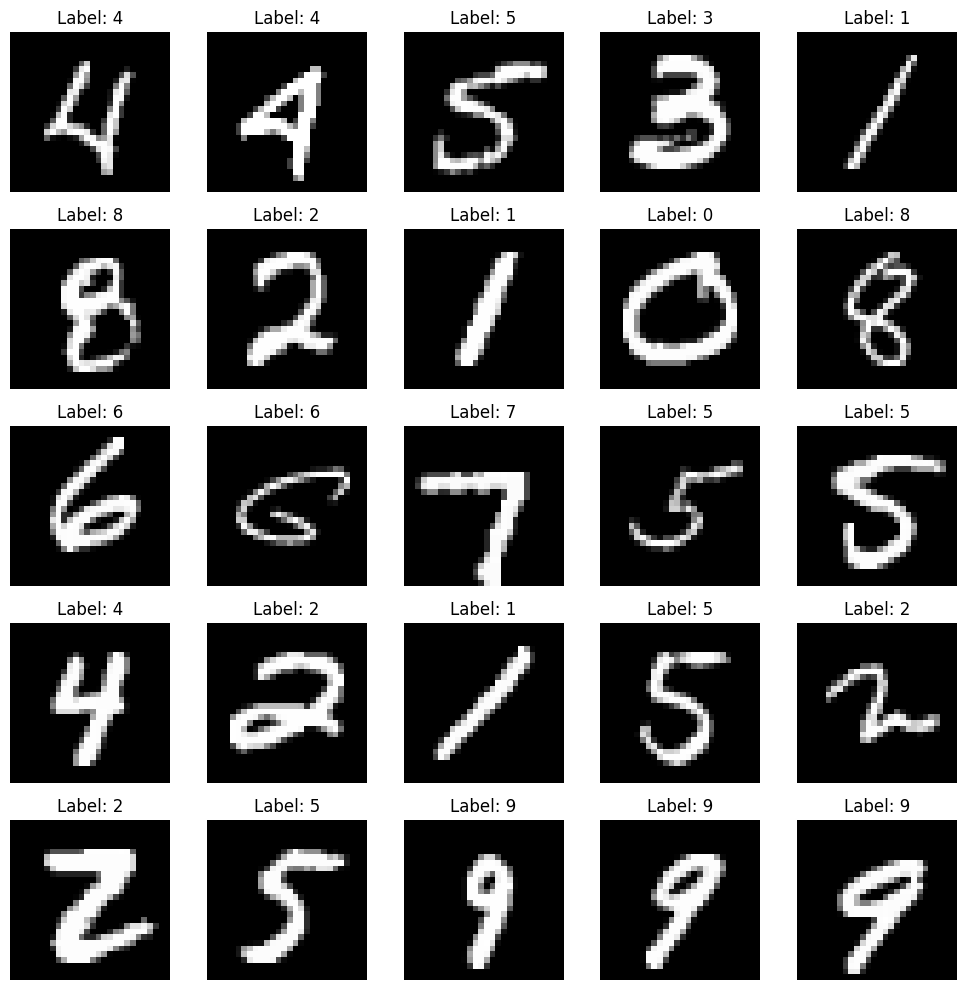

In [29]:
num_images = 25  # Number of images to display
indices = np.random.choice(train_df.shape[0], num_images, replace=False)
images = x[indices]
labels = y[indices]

# Create a grid of images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for ax, img, label in zip(axes.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

**Encoding for labels**

In [40]:
y=to_categorical(y,num_classes=10)

**Splitting the MNIST Dataset**

In [41]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=2)

**Define the model**



Output layer: Number of neurons = 10 (corresponding to 0 to 9 digits)


*   1st hidden layer: Number of neurons = 32
*   2st hidden layer: Number of neurons = 64
*   2st hidden layer: Number of neurons = 256
*   all hidden layer: Activation Function = relu (for non-linearity detection)
*   Output layer: Activation Function = softmax to get probabilities for the
*   1st Output layer: Number of neurons = 256
*   Output layer: Number of neurons = 10 (corresponding to 0 to 9 digits)
*   repective 10 classes



In [42]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Define the optimizer function, loss function and metrics to be used for the model.**

* Going ahead with the well known functions at this point in time
* Selected accuracy as the metrics to understand validation / test accuracy of the model

In [43]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [44]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [45]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

**Data Generator for increase numbers of datat avoid overfiting**

In [46]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

**Train the Model**

* We will use a batch size = 64.
* 1 epoch =x_train.shape[0] // 64 batches
* 1 epoch = 1 complete run of all train samples for training the model
* We will go for a total of 1 epochs = 1 complete run of the all train samples

In [48]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=16),
                              epochs = 1, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // 16
                              , callbacks=[learning_rate_reduction])

2100/2100 - 21s - 10ms/step - accuracy: 0.9536 - loss: 0.1572 - val_accuracy: 0.9849 - val_loss: 0.0496 - learning_rate: 0.0010


* accuracy model : 0.9536
* val_accuracy: 0.9923

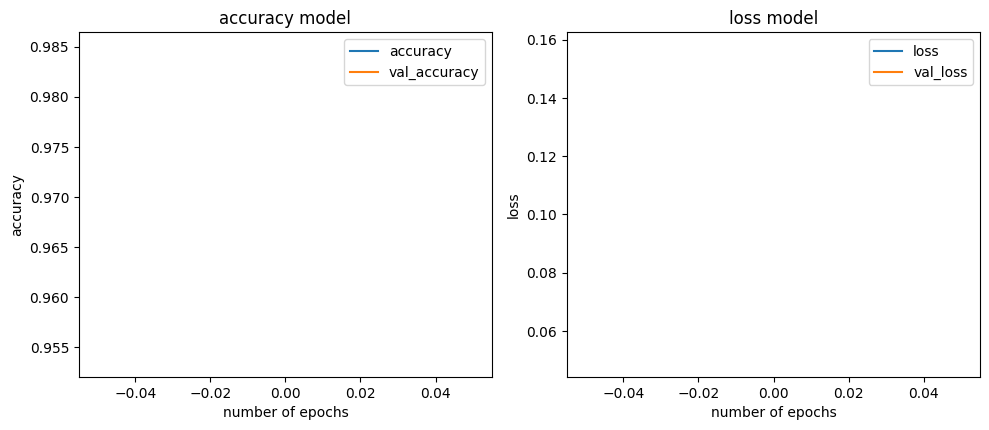

In [49]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy model')
plt.xlabel('number of epochs')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss model')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


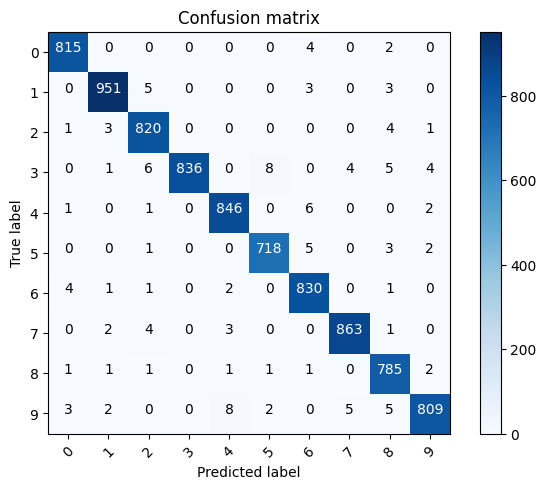

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(10))

In [51]:
loss_model,accuracy_model=model.evaluate(x_train,y_train)
print(f'accuracy model on test data : {accuracy_model*100} %')
print(f'loss model on test data : {loss_model} ')

1050/1050 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9875 - loss: 0.0409
accuracy model on test data : 98.74702095985413 %
loss model on test data : 0.04231010377407074 


In [96]:
def predict_image_show(image):
  org_image = image
  single_image = np.expand_dims(org_image, axis=0)
  predictions = model.predict(single_image)
  predict_class=np.argmax(predictions,axis=1)
  plt.imshow(image ,cmap='gray')
  plt.title(f'Predicted Class: {predict_class[0]}')
  plt.axis('off')
  plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


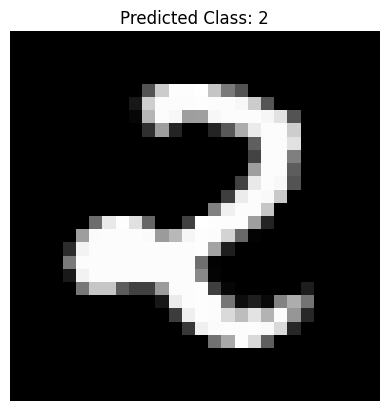

In [97]:
predict_image_show(x_test[5])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


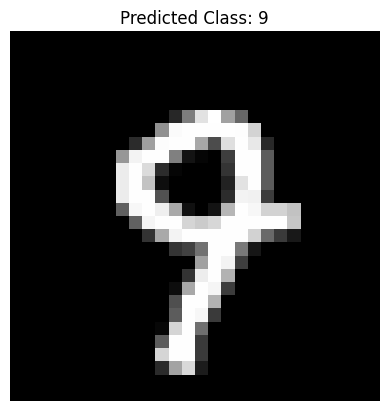

In [98]:
predict_image_show(x_test[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


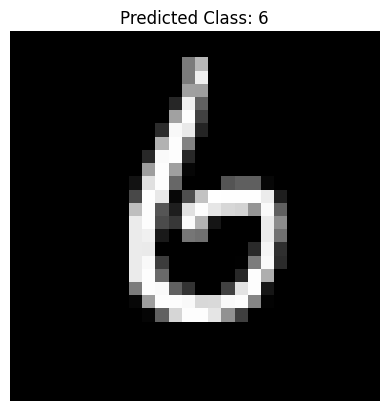

In [99]:
predict_image_show(x_test[50])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


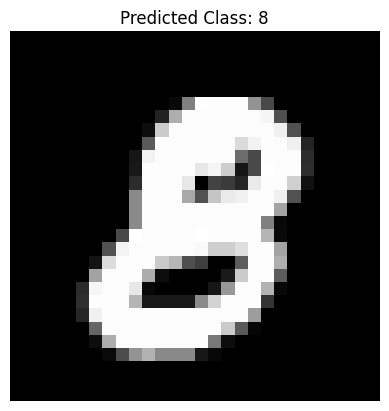

In [100]:
predict_image_show(x_test[1000])